# Solving the cart pole problem based on the state variables of the environment (using deep Q-neural networks)

The four states variables of the environment are: 

Cart Position, Cart Velocity, Pole Angle and Pole Angular Velocity.

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display  

## Creating a tuple type for storing experiences

In [3]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

## Setting up the deep Q-neural network 

The neural network used is a Multilayer Perceptron with 4 neurons as its entry (the four state variables), 24 neuros at the first hidden layer, 32 neuros at the second hidden layer and 2 neurons at its output (left and right - two possible actions to be taken).

In [4]:
class DQN(nn.Module):
    
    def __init__(self, num_state_features):
        super().__init__()
         
        self.fc1 = nn.Linear(in_features=num_state_features, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)            

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Creating a ReplayMemory for storing and managing the collected experiences

In [5]:
class ReplayMemory():
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Creating class for managing the Exploration - Exploitation bias (by using the Epsilon Greedy strategy)

In [6]:
class EpsilonGreedyStrategy():
    
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end)*math.exp(-current_step*self.decay)

## Creating class to implement the agent that decides which action is to be taken given the current state

In [7]:
class Agent():
    
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(self.device) # exploit

## Creating class that manages the cart pole environment (applies action chosen by Agent and collects state variables)

In [8]:
class CartPoleEnvManager():
    
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.done = False
        self.current_state = None
        
    # Resets environment if episodes reaches its end
    def reset(self):
        self.current_state = self.env.reset()
        
    # Closes environment
    def close(self):
        self.env.close()

    # Applies action chosen by the Agent
    def take_action(self, action):        
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    # Gets current state
    def get_state(self):
        if self.done:
            return torch.zeros_like(torch.tensor(self.current_state), device=self.device).float()
        else:
            return torch.tensor(self.current_state, device=self.device).float()

    # Shows the image of the cart pole environment
    def render(self, mode='human'):
        return self.env.render(mode)
    
    # Gets number of possible actions to be taken
    def num_actions_available(self):
        return self.env.action_space.n
    
    # Gets number of possible states to be in
    def num_state_features(self):
        return self.env.observation_space.shape[0]

## Functions used to plot the moving average of the rewards obtained by the reinforcement learning algorithm

In [9]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [10]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

## Function used to extract information from the experience special tuple type

In [11]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.stack(batch.state)
    t2 = torch.stack(batch.action)
    t3 = torch.stack(batch.reward)
    t4 = torch.stack(batch.next_state)

    return (t1,t2,t3,t4)

## Class used for the training of the deep Q-neural network

In [12]:
class QValues():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions)
    
    @staticmethod        
    def get_next(target_net, next_states):                
        #final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        final_state_locations = next_states.max(dim=1)[0].eq(0).type(torch.bool)
        #print(next_states.size())
        #print(final_state_locations.size())
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Setting up parameters for the training of the deep Q-neural network

In [13]:
batch_size = 256 # size of the memories batch to train the policy net
gamma = 0.999 # used to calculate expected total reward

# Epsilon Greedy strategy parameters
eps_start = 1
eps_end = 0.01
eps_decay = 0.001


target_update = 10 # update target net after 10 training epochs of policy net
memory_size = 100000 # maximum replay memory size
lr = 0.001 # learning rate for the training of policy net
lr_decay = 0.99 # decaynof the learning rate
num_episodes = 150 # number of episodes considered during policy net's training
mov_avg_per = 10 # moving average period

## Setting up cart pole manager and Epsilon Greedy strategy

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

/home/lizarzgu/.local/share/virtualenvs/PoleProjetS8-jl3j6xPV/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


## Setting up agent and replay memory

In [15]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

## Setting up deep Q-neural networks

Policy net is the network used to determine the actions taken by the agent and the target net is the network used to avoid instabilities during policy net's training.

In [16]:
policy_net = DQN(em.num_state_features()).to(device)
target_net = DQN(em.num_state_features()).to(device)

In [17]:
# Loading the targt net with policy net's synaptic weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [18]:
# Optimizer for the policy net's training
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

## Running reinforcement learning algorithm

The longer the duration of the episode, the better the performance.

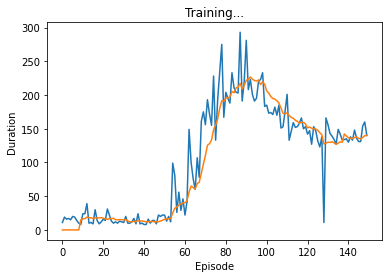

Episode 150 
 10 episode moving avg: 140.1


In [19]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net) # selecting action to be taken
        reward = em.take_action(action) # taking action and collecting respective reward
        next_state = em.get_state() # getting current state
        memory.push(Experience(state, action, next_state, reward)) # storing experience at the replay memory
        state = next_state # updating current state variable
        
        if memory.can_provide_sample(batch_size): # if replay memory has, at least, batch_size (256) memories
            experiences = memory.sample(batch_size) # random samples batch_size (256) memories from replay memory
            states, actions, rewards, next_states = extract_tensors(experiences) # extract information from obtained experiences tuples

            # calculating current Q-values and target Q-values
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values.unsqueeze(-1)*gamma) + rewards

            # training policy net based on mean squared loss
            loss = F.mse_loss(current_q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done: # if episode is finished
            episode_durations.append(timestep)
            plot(episode_durations, mov_avg_per)
            break
            
    # updating target net
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

## Playing one episode of the cart pole environment (after training)

In [ ]:
em.reset()
state = em.get_state()

for timestep in count():

    with torch.no_grad():
        action = policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(device) # exploit 
    _ = em.take_action(action)
    state = em.get_state()
    screen = em.render("rgb_array")

    plt.imshow(screen)
    plt.title("Timestep: " + str(timestep))
    plt.show()
    plt.pause(0.001)
    
    if em.done:
        print("Done!")
        break
        
    if is_ipython: display.clear_output(wait=True)